In [ ]:
"""
Setting for google colab
"""
# The path of your project on google drive
path_project = "/content/drive/MyDrive/cartography msc/Thesis TUM 2024/"

# Connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

# Set the project path as current working directory
import os
os.chdir(path_project)
print("Current files under the working directory:", os.listdir())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current files under the working directory: ['momepy', 'NetworkX', 'Ground_truth.ipynb', 'Asia_Korail_Morphometrics_training+testing.ipynb', 'Asia_Korail_topology_training+testing.ipynb', 'buildings.gsheet', 'gdf_nodes.gsheet', 'All in one notebook.ipynb', 'buildings.csv', 'centroids_gdf.csv', 'joined_gdf.csv', 'shapefiles slums', 'cache', 'All in one notebook_tra&test.ipynb', ' Paraguay_All in one notebook_tra&test.ipynb', 'more features_machine learning_kmeans_All in one notebook_Korail.ipynb', 'merged_df.csv', 'joined.csv', ' Training_Stepwise searching_3metrics_Korail_Bangladesh.ipynb', 'Testing2_RicardoBrugada_Paraguay_RF.ipynb', 'Testing1_Katanga_Uganda_RF.ipynb', 'rf_model_korail.pkl', 'MACHINE LEARNING', 'writing', 'rf_model_korail_morpho.pkl', 'rf_model_korail_topo.pkl']


In [ ]:
!pip install momepy
!pip install osmnx

!pip install matplotlib-scalebar
!pip install basemap


In [ ]:
import joblib
import geopandas as gpd
import numpy as np
import momepy as mm
import osmnx as ox
import networkx as nx
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.spatial.distance import euclidean
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.basemap import Basemap


In [ ]:

# Load the trained model
model_path = "/content/drive/MyDrive/cartography msc/Thesis TUM 2024/rf_model_korail_topo.pkl"
rf_classifier_Korail = joblib.load(model_path)
print("Model loaded from", model_path)


Model loaded from /content/drive/MyDrive/cartography msc/Thesis TUM 2024/rf_model_korail_topo.pkl


In [ ]:
# Morphology + Topology metrics
# Data processing and prediction using the loaded model (rf_classifier_Korail)

def process_and_predict(point, dist, rf_classifier_Korail):
    gdf = ox.geometries.geometries_from_point(point, dist=dist, tags={'building':True})
    gdf_projected = ox.projection.project_gdf(gdf)
    buildings = gdf_projected[gdf_projected.geom_type.isin(['Polygon', 'MultiPolygon'])]
    buildings['uID'] = mm.unique_id(buildings)
    limit = mm.buffered_limit(buildings)
    tessellation = mm.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

    buildings['area'] = mm.Area(buildings).series
    buildings['perimeter'] = mm.Perimeter(buildings).series
    buildings['lal'] = mm.LongestAxisLength(buildings).series
    sw1 = mm.sw_high(k=1, gdf=tessellation, ids='uID')
    buildings['neighbour_dist'] = mm.NeighborDistance(buildings, sw1, 'uID').series
    MID = mm.MeanInterbuildingDistance(buildings, sw1, 'uID')
    buildings['mean_interbuilding_distance'] = MID.series
    buildings['circular_com'] = mm.CircularCompactness(buildings).series
    buildings['elongation'] = mm.Elongation(buildings).series
    tessellation['area'] = mm.Area(tessellation).series
    buildings['area'] = mm.Area(buildings).series
    tess_car = mm.AreaRatio(tessellation, buildings, 'area', 'area', 'uID')
    tessellation['CAR'] = tess_car.series
    tes_cwa = mm.CompactnessWeightedAxis(tessellation)
    tessellation['cwa'] = tes_cwa.series
    tessellation['tes_area'] = mm.Area(tessellation).series
    buildings['fractal'] = mm.FractalDimension(buildings, 'area', 'perimeter').series

    def multipolygon_centroid(geom):
        if geom.geom_type == 'MultiPolygon':
            return geom.convex_hull.centroid
        else:
            return geom.centroid

    buildings['centroid'] = buildings.geometry.apply(multipolygon_centroid)
    centroids_gdf = gpd.GeoDataFrame({'uID': buildings['uID'], 'geometry': buildings['centroid']}, crs=buildings.crs)
    coordinates = np.column_stack((centroids_gdf.geometry.x, centroids_gdf.geometry.y))
    from scipy.spatial import Delaunay
    tri = Delaunay(coordinates)
    G = nx.Graph()

    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                G.add_edge(simplex[i], simplex[j])
                p1 = coordinates[simplex[i]]
                p2 = coordinates[simplex[j]]
                distance = euclidean(p1, p2)
                G.add_edge(simplex[i], simplex[j], weight=distance)

    node_avg_weighted_distance = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        total_weighted_distance = 0.0
        count = 0
        for neighbor in neighbors:
            weight = G[node][neighbor]['weight']
            total_weighted_distance += weight
            count += 1
        avg_weighted_distance = total_weighted_distance / count if count > 0 else 0.0
        node_avg_weighted_distance[node] = avg_weighted_distance

    centroids_gdf = centroids_gdf.reset_index(drop=True)
    centroids_gdf['avg_weighted_distance'] = centroids_gdf.index.map(node_avg_weighted_distance)

    joined_gdf = gpd.GeoDataFrame(buildings.merge(centroids_gdf, on='uID', how='left', suffixes=('_building', '_centroid')), geometry='geometry_building', crs=buildings.crs)
    joined_gdf = joined_gdf.merge(tessellation, on='uID', how='left', suffixes=('', '_tessellation'))
    joined_gdf['avg_weighted_distance'] = joined_gdf['avg_weighted_distance'].fillna(0)
    features = joined_gdf[['area', 'perimeter', 'lal', 'neighbour_dist', 'mean_interbuilding_distance', 'circular_com', 'elongation', 'cwa', 'CAR', 'tes_area', 'fractal', 'avg_weighted_distance']]

    predictions = rf_classifier_Korail.predict(features)
    joined_gdf['pred_label'] = predictions

    return joined_gdf


In [ ]:
# Coordinates Katanga and Ricardo Brugada
Point_Katanga_Uganda = (0.335044, 32.575066)
Point_Ricardo_Paraguay = (-25.28004691495517, -57.624719589548526)
dist_ug = 700
dist_par = 1200

# Process and predict for Uganda
uganda_gdf = process_and_predict(Point_Katanga_Uganda, dist_ug, rf_classifier_Korail)

# Process and predict for Paraguay

paraguay_gdf = process_and_predict(Point_Ricardo_Paraguay, dist_par, rf_classifier_Korail)

<ipython-input-9-ce847e2e06ce>:5: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries.geometries_from_point(point, dist=dist, tags={'building':True})
<ipython-input-9-ce847e2e06ce>:10: FutureWarning: Class based API like `momepy.Tessellation` is deprecated. Replace it with `momepy.morphological_tessellation` or `momepy.enclosed_tessellation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation = mm.Tessellation(buildings, unique_id='uID', limit=limit).tessellation


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


<ipython-input-9-ce847e2e06ce>:10: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. `unique_id` of affected elements: [1828, 2220, 558, 2380, 1737, 1765, 793, 1030].
  tessellation = mm.Tessellation(buildings, unique_id='uID', limit=limit).tessellation
<ipython-input-9-ce847e2e06ce>:12: FutureWarning: `momepy.Area` is deprecated. Replace it with `.area` attribute of a GeoDataFrame or pin momepy version <1.0. This class will be removed in 1.0. 
  buildings['area'] = mm.Area(buildings).series
<ipython-input-9-ce847e2e06ce>:13: FutureWarning: `momepy.Perimeter` is deprecated. Replace it with `.length` attribute of a GeoDataFrame or pin momepy version <1.0. This class will be removed in 1.0. 
  buildings['perimeter'] = mm.Perimeter(buildings).series
<ipython-input-9-ce847e2e06ce>:14: FutureWarning: Class based API like `momepy.LongestAxisLength` is deprecated. Replace it with `momepy.longest_axis_length` to use functional API instead or pin momep

  0%|          | 0/2632 [00:00<?, ?it/s]

Computing mean interbuilding distances...


<ipython-input-9-ce847e2e06ce>:17: FutureWarning: Class based API like `momepy.MeanInterbuildingDistance` is deprecated. Replace it with `momepy.mean_interbuilding_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  MID = mm.MeanInterbuildingDistance(buildings, sw1, 'uID')


  0%|          | 0/2632 [00:00<?, ?it/s]

<ipython-input-9-ce847e2e06ce>:19: FutureWarning: Class based API like `momepy.CircularCompactness` is deprecated. Replace it with `momepy.circular_compactness` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['circular_com'] = mm.CircularCompactness(buildings).series
<ipython-input-9-ce847e2e06ce>:20: FutureWarning: Class based API like `momepy.Elongation` is deprecated. Replace it with `momepy.elongation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['elongation'] = mm.Elongation(buildings).series
<ipython-input-9-ce847e2e06ce>:21: FutureWarning: `momepy.Area` is deprecated. Replace it with `.area` attribute of a GeoDataFrame or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['area'] = mm.Area(tessellation).series
<ipython-input-9-ce847e2e06ce>:22: FutureWarning: `momepy.Area` is deprecated. Replace it with `.area` attribute of a G

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


<ipython-input-9-ce847e2e06ce>:10: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should  be edited. `unique_id` of affected elements: [5475, 1085, 6058, 1086, 6057, 2228, 6052, 5489, 6051, 1089, 6050, 1090, 6049, 1171, 2524, 64, 1856, 5649, 2915, 1091, 6041, 1621, 1652, 6043, 1638, 197, 6040, 6059, 152, 56, 6755, 5663, 2917, 5662, 5666, 2916, 5668, 2914, 5652, 5671, 5697, 5651, 5696, 2913, 5690, 3247, 398, 395, 400, 396, 3448].
  tessellation = mm.Tessellation(buildings, unique_id='uID', limit=limit).tessellation
<ipython-input-9-ce847e2e06ce>:12: FutureWarning: `momepy.Area` is deprecated. Replace it with `.area` attribute of a GeoDataFrame or pin momepy version <1.0. This class will be removed in 1.0. 
  buildings['area'] = mm.Area(buildings).series
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

  0%|          | 0/6759 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-9-ce847e2e06ce>:17: FutureWarning: Class based API like `momepy.MeanInterbuildingDistance` is deprecated. Replace it with `momepy.mean_interbuilding_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  MID = mm.MeanInterbuildingDistance(buildings, sw1, 'uID')


Computing mean interbuilding distances...


  0%|          | 0/6759 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-9-ce847e2e06ce>:19: FutureWarning: Class based API like `momepy.CircularCompactness` is deprecated. Replace it with `momepy.circular_compactness` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['circular_com'] = mm.CircularCompactness(buildings).series
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

# Model evaluation

In [ ]:

# Katanga - Uganda - Ground truth
gdf2 = ox.geometries.geometries_from_point(Point_Katanga_Uganda, dist=dist_ug, tags={'residential':['irregular_settlement']})
gdf_projected_2 = ox.projection.project_gdf(gdf2)
Katanga = gdf_projected_2[gdf_projected_2.geom_type.isin(['Polygon', 'MultiPolygon'])]
Katanga['uID'] = mm.unique_id(Katanga)
Katanga_union = Katanga.unary_union
uganda_gdf['label'] = np.where(uganda_gdf.within(Katanga_union), 'slum', 'non-slum')

#Evaluate comparing ground truth
accuracy_uganda = accuracy_score(uganda_gdf['label'], uganda_gdf['pred_label'])
print(f"Accuracy for Uganda: {accuracy_uganda:.2f}")

conf_matrix_uganda = confusion_matrix(uganda_gdf['label'], uganda_gdf['pred_label'])
print("Confusion Matrix for Uganda:")
print(conf_matrix_uganda)
class_report_uganda = classification_report(uganda_gdf['label'], uganda_gdf['pred_label'])
print("Classification Report for Uganda:")
print(class_report_uganda)


<ipython-input-11-ac402a57cbbe>:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf2 = ox.geometries.geometries_from_point(Point_Katanga_Uganda, dist=dist_ug, tags={'residential':['irregular_settlement']})


Accuracy for Uganda: 0.70
Confusion Matrix for Uganda:
[[1430  111]
 [ 682  409]]
Classification Report for Uganda:
              precision    recall  f1-score   support

    non-slum       0.68      0.93      0.78      1541
        slum       0.79      0.37      0.51      1091

    accuracy                           0.70      2632
   macro avg       0.73      0.65      0.65      2632
weighted avg       0.72      0.70      0.67      2632



In [ ]:
#OVERALL ACCURACY

# Number of correct predictions
correct_predictions = (uganda_gdf['pred_label'] == uganda_gdf['label']).sum()

# Total number of predictions
total_predictions = len(uganda_gdf)

# Overall accuracy
o_accuracy = correct_predictions / total_predictions

print(f"Overall Accuracy: {o_accuracy * 100:.2f}%")

Overall Accuracy: 69.87%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import geopandas as gpd

# Function to plot the geometries with Matplotlib
def plot_geometries(gdf, title, label_column='pred_label'):
    f, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(column=label_column, cmap='coolwarm', alpha=.7, legend=True, ax=ax,
                legend_kwds={'loc': 'lower right', 'title': "Legend"})
    # Add scale bar with transparency
    scalebar = ScaleBar(1, location='lower left', pad=1, box_alpha=0.5)
    ax.add_artist(scalebar)

    # Add north arrow with customized design
    x, y, arrow_length = 0.04, 1, 0.08
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', headwidth=15, headlength=20, width=5),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)
    # Add resource text
    plt.text(0.5, 0.02, 'Data source: OpenStreetMap', horizontalalignment='center',
         verticalalignment='center', transform=ax.transAxes, fontsize=7)
    plt.title(title)
    ax.set_axis_off()
    plt.show()


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


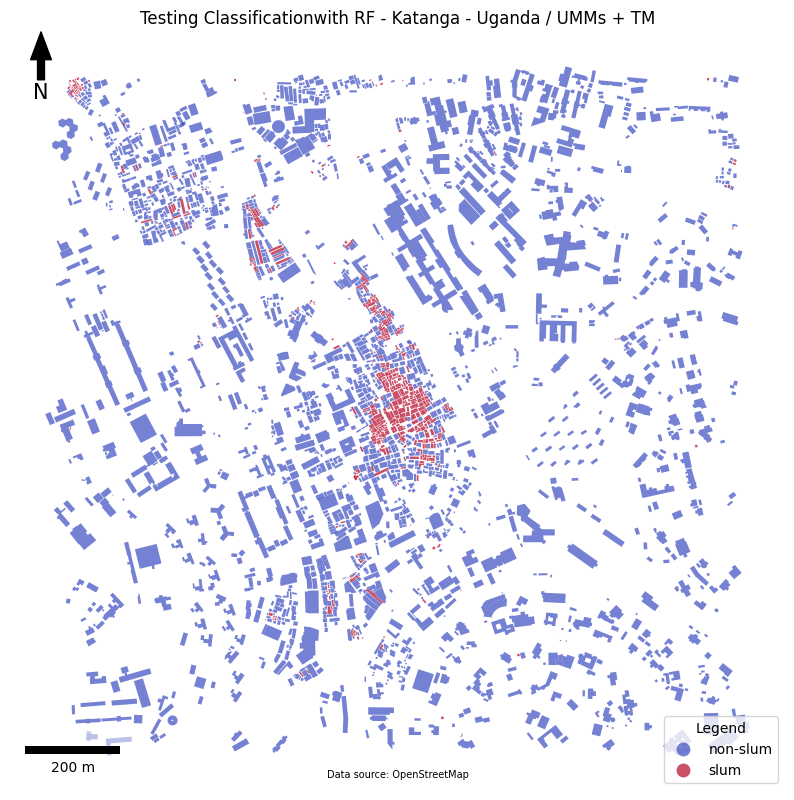

label
non-slum    1541
slum        1091
Name: count, dtype: int64


In [ ]:
# Plot: Results for Katanga - Uganda
plot_geometries(uganda_gdf, "Testing Classificationwith RF - Katanga - Uganda / UMMs + TM")
print(uganda_gdf['label'].value_counts())

In [ ]:

# Ricardo Brugada - Paraguay - Ground truth
gdf3 = ox.geometries.geometries_from_point(Point_Ricardo_Paraguay, dist=dist_par, tags={'residential':['irregular_settlement']})
gdf_projected_3 = ox.projection.project_gdf(gdf3)
Ricardo = gdf_projected_3[gdf_projected_3.geom_type.isin(['Polygon', 'MultiPolygon'])]
Ricardo['uID'] = mm.unique_id(Ricardo)
ricardo_brugada_union = Ricardo.unary_union
paraguay_gdf['label'] = np.where(paraguay_gdf.within(ricardo_brugada_union), 'slum', 'non-slum')

#Evaluate comparing ground truth
accuracy_paraguay = accuracy_score(paraguay_gdf['label'], paraguay_gdf['pred_label'])
print(f"Accuracy for Paraguay: {accuracy_paraguay:.2f}")
conf_matrix_paraguay = confusion_matrix(paraguay_gdf['label'], paraguay_gdf['pred_label'])
print("Confusion Matrix for Paraguay:")
print(conf_matrix_paraguay)
class_report_paraguay = classification_report(paraguay_gdf['label'], paraguay_gdf['pred_label'])
print("Classification Report for Paraguay:")
print(class_report_paraguay)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-15-7501ef1f86f6>:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf3 = ox.geometries.geometries_from_point(Point_Ricardo_Paraguay, dist=dist_par, tags={'residential':['irregular_settlement']})


Accuracy for Paraguay: 0.65
Confusion Matrix for Paraguay:
[[4170  164]
 [2196  229]]
Classification Report for Paraguay:
              precision    recall  f1-score   support

    non-slum       0.66      0.96      0.78      4334
        slum       0.58      0.09      0.16      2425

    accuracy                           0.65      6759
   macro avg       0.62      0.53      0.47      6759
weighted avg       0.63      0.65      0.56      6759



In [ ]:
#OVERALL ACCURACY

# Number of correct predictions
correct_predictions = (paraguay_gdf['pred_label'] == paraguay_gdf['label']).sum()

# Total number of predictions
total_predictions = len(paraguay_gdf)

# Overall accuracy
o_accuracy = correct_predictions / total_predictions

print(f"Overall Accuracy: {o_accuracy * 100:.2f}%")

Overall Accuracy: 65.08%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


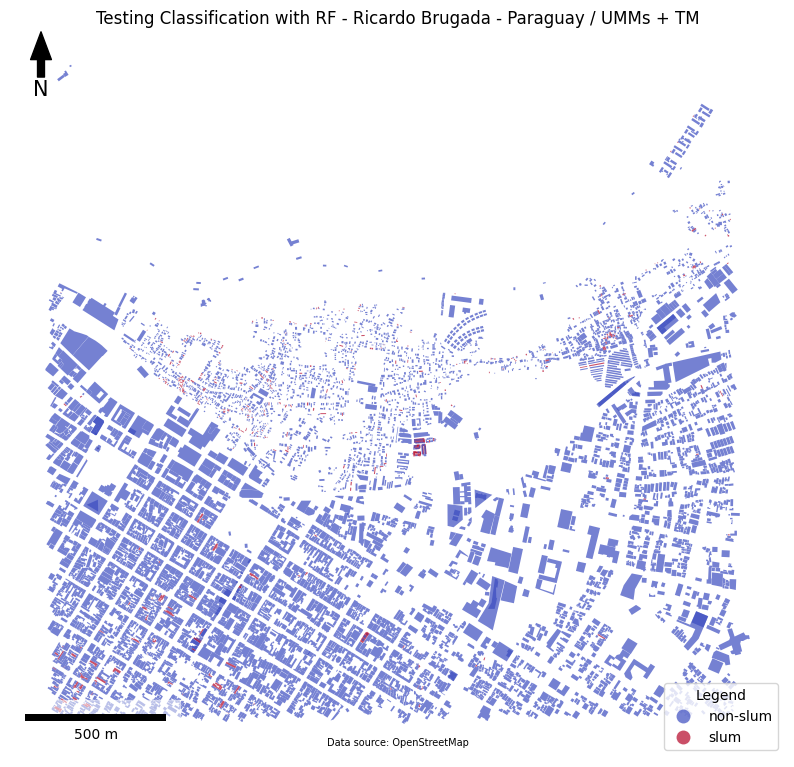

In [ ]:
# Results for Ricardo Brugada - Paraguay
plot_geometries(paraguay_gdf, "Testing Classification with RF - Ricardo Brugada - Paraguay / UMMs + TM")

In [ ]:
print(paraguay_gdf['label'].value_counts())

label
non-slum    4334
slum        2425
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
